# JAX类型提升语义的设计

[![在Colab中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jep/9407-type-promotion.ipynb) [![在Kaggle中打开](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/jep/9407-type-promotion.ipynb)

*杰克·范德普拉斯，2021年12月*

在任何数值计算库的设计中，面临的挑战之一是如何处理不同类型值之间的操作。本文档概述了JAX使用的提升语义背后的思考过程，具体总结见[JAX类型提升语义](https://jax.readthedocs.io/en/latest/type_promotion.html)。


## JAX 类型提升的目标

JAX 的数值计算 API 模仿了 NumPy 的 API，并进行了一些增强，包括能够针对 GPU 和 TPU 等加速器。这使得 NumPy 的类型提升系统对 JAX 用户来说是不利的：NumPy 的类型提升规则高度偏向于 64 位输出，这在加速器计算中存在问题。像 GPU 和 TPU 这样的设备在使用 64 位浮点类型时通常会付出显著的性能代价，在某些情况下根本不支持原生的 64 位浮点类型。

在 32 位整数和浮点数之间进行二进制操作时，可以看到这种有问题的类型提升语义的简单示例：


In [1]:
import numpy as np
np.dtype(np.int32(1) + np.float32(1))


dtype('float64')

NumPy倾向于产生64位值是一个[长期存在的问题](https://github.com/numpy/numpy/issues/6860)，在使用NumPy的API进行加速计算时，这个问题仍然没有好的解决方案。因此，JAX试图重新思考NumPy风格的类型提升，以考虑加速器的需求。


## 退一步：表格和格子

在我们深入细节之前，先花一点时间回顾一下*如何*思考类型提升的问题。考虑Python中内置数值类型之间的算术操作，即类型为`int`、`float`和`complex`的那些。通过几行代码，我们可以生成Python用于这些类型值相加的类型提升表：


In [2]:
import pandas as pd
types = [int, float, complex]
name = lambda t: t.__name__
pd.DataFrame([[name(type(t1(1) + t2(1))) for t1 in types] for t2 in types],
             index=[name(t) for t in types], columns=[name(t) for t in types])


int    float  complex
int          int    float  complex
float      float    float  complex
complex  complex  complex  complex

这张表列出了Python的数值类型提升行为，但实际上有一种更紧凑的补充表示：一个 [格](https://en.wikipedia.org/wiki/Lattice_(order)) 表示，在任何两个节点之间的 [上确界](https://en.wikipedia.org/wiki/Infimum_and_supremum) 是它们提升到的类型。Python提升表的格表示要简单得多：


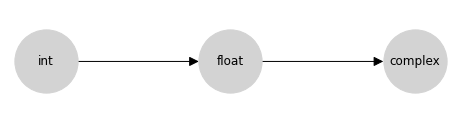

In [3]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {'int': ['float'], 'float': ['complex']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'int': [0, 0], 'float': [1, 0], 'complex': [2, 0]}
fig, ax = plt.subplots(figsize=(8, 2))
nx.draw(graph, with_labels=True, node_size=4000, node_color='lightgray', pos=pos, ax=ax, arrowsize=20)


这个格是上面提升表信息的紧凑编码。您可以通过追踪图到两个节点（包括节点自身）的第一个共同子节点，找到两个输入的类型提升结果；在数学上，这个共同子节点被称为*上确界*、或*最小上界*、或*并*；在这里我们将这个操作称为**并**。

从概念上讲，箭头意味着*允许在源和目标之间进行隐式类型提升*：例如，允许从整数到浮点数的隐式提升，但不允许从浮点数到整数的隐式提升。

请记住，通常并不是每个有向无环图（DAG）都满足格的属性。一个格要求每对节点都存在唯一的最小上界；因此，例如以下两个DAG就不是格：


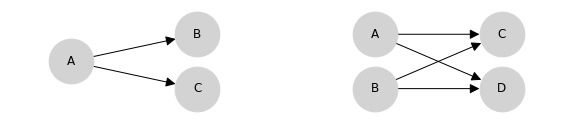

In [4]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 2))

lattice = {'A': ['B', 'C']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'A': [0, 0], 'B': [1, 0.5], 'C': [1, -0.5]}
nx.draw(graph, with_labels=True, node_size=2000, node_color='lightgray', pos=pos, ax=ax[0], arrowsize=20)
ax[0].set(xlim=[-0.5, 1.5], ylim=[-1, 1])

lattice = {'A': ['C', 'D'], 'B': ['C', 'D']}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {'A': [0, 0.5], 'B': [0, -0.5], 'C': [1, 0.5], 'D': [1, -0.5]}
nx.draw(graph, with_labels=True, node_size=2000, node_color='lightgray', pos=pos, ax=ax[1], arrowsize=20)
ax[1].set(xlim=[-0.5, 1.5], ylim=[-1, 1]);


左侧的有向无环图不是一个格，因为节点 `B` 和 `C` 没有上界；右侧的有向无环图存在两个问题：首先，节点 `C` 和 `D` 没有上界，对于节点 `A` 和 `B`，最小上界无法*唯一*确定：`C` 和 `D` 都是候选者，但它们是不可比较的。


### 类型提升格的性质

用格来指定类型提升确保了许多有用的性质。我们用 $\vee$ 运算符来表示格上的结合，我们有：

**存在性：** 根据定义，格要求每一对元素都有唯一的格结合：$\forall (a, b): \exists !(a \vee b)$

**交换性：** 格结合是交换的：$\forall (a, b): a\vee b = b \vee a$。

**结合性：** 格结合是结合的：$\forall (a, b, c): a \vee (b \vee c) = (a \vee b) \vee c$。

另一方面，这些性质对它们可以表示的类型提升系统施加了限制；特别是 **并非每个类型提升表都可以用格来表示**。NumPy 的完整类型提升表就是一个明显的例子；我们可以通过反例快速说明这一点：下面是三个在 NumPy 中提升行为不满足结合律的标量类型：


In [5]:
import numpy as np
a, b, c = np.int8(1), np.uint8(1), np.float16(1)
print(np.dtype((a + b) + c))
print(np.dtype(a + (b + c)))


float32
float16


这样的结果可能会让用户感到惊讶：我们通常期望数学表达式对应于数学概念，因此，例如，`a + b + c` 应该等价于 `c + b + a`；`x * (y + z)` 应该等价于 `x * y + x * z`。如果类型提升是非结合的或非交换的，这些性质将不再适用。

此外，与基于表格的系统相比，基于格的类型提升系统更易于概念化和理解。例如，JAX 识别 18 种不同的类型：一个由 18 个节点组成的提升格及其之间稀疏且合理的连接，远比包含 324 个条目的表格更容易记忆。

因此，我们选择在 JAX 中使用基于格的类型提升系统。


## 类别内的类型提升

数值计算库通常提供的不仅仅是 `int`、`float` 和 `complex`；在每个类别内，都有多种可能的精度，表示为数值表示中使用的位数。我们在这里考虑的类别包括：

- *无符号整数*，包括 `uint8`、`uint16`、`uint32` 和 `uint64`（我们将简写为 `u8`、`u16`、`u32`、`u64`）
- *有符号整数*，包括 `int8`、`int16`、`int32` 和 `int64`（我们将简写为 `i8`、`i16`、`i32`、`i64`）
- *浮点数*，包括 `float16`、`float32` 和 `float64`（我们将简写为 `f16`、`f32`、`f64`）
- *复浮点数*，包括 `complex64` 和 `complex128`（我们将简写为 `c64`、`c128`）

Numpy 在这四个类别 **内部** 的类型提升语义相对简单：有序的类型层次直接转换为四个独立的格子，表示类别内的类型提升规则：


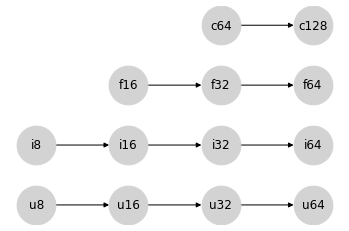

In [6]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'u8': [0, 0], 'u16': [1, 0], 'u32': [2, 0], 'u64': [3, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1, 2], 'f32': [2, 2], 'f64': [3, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


在JAX希望避免的值提升到64位的情况中，每个类型类别内的同类提升语义是没有问题的：产生64位输出的唯一方式是有64位输入。


## 输入Python标量

现在让我们思考Python标量在这个混合中的位置。

在NumPy中，提升行为取决于输入是数组还是标量。例如，在两个标量上进行操作时，适用正常的提升规则：


In [7]:
x = np.int8(0)  # int8 标量
y = 1  # Python 整数 = 64位标量整数
(x + y).dtype


dtype('int64')

在这里，Python值`1`被视为`int64`，并且直接的同类规则导致结果为`int64`。

然而，在Python标量与NumPy数组之间的操作中，标量会服从数组的dtype。例如：


In [8]:
x = np.zeros(1, dtype='int8')  # int8 数组
y = 1  # Python 整数 = 64位标量
(x + y).dtype


dtype('int8')

这里的 `int64` 标量的位宽被忽略，转而依赖于数组的位宽。

这里还有一个细节：当 NumPy 类型提升涉及到标量时，输出的数据类型是依赖于值的：如果 Python 标量对于给定的数据类型来说过大，它会被提升到一个兼容的类型：


In [9]:
x = np.zeros(1, dtype='int8')  # int8 数组
y = 1000  # 64位整数标量
(x + y).dtype


dtype('int16')

对于JAX的目的来说，**值依赖提升是一个不可能实现的目标**，这是因为JIT编译和其他变换的特性，它们作用于数据的抽象表示，而不考虑它们的值。


忽略值相关的影响，NumPy 类型提升的有符号整数分支可以通过以下格子表示，我们将使用 `*` 来标记标量数据类型：


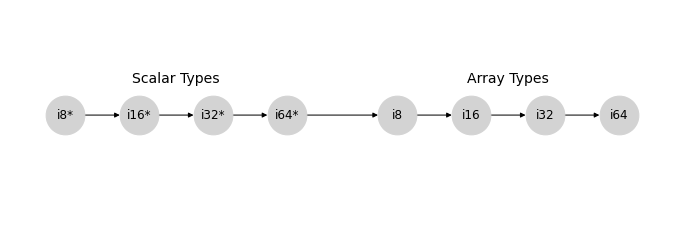

In [10]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i8*': ['i16*'], 'i16*': ['i32*'], 'i32*': ['i64*'], 'i64*': ['i8'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i8*': [0, 1], 'i16*': [2, 1], 'i32*': [4, 1], 'i64*': [6, 1],
  'i8': [9, 1], 'i16': [11, 1], 'i32': [13, 1], 'i64': [15, 1],
}
fig, ax = plt.subplots(figsize=(12, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)
ax.text(3, 1.6, "Scalar Types", ha='center', fontsize=14)
ax.text(12, 1.6, "Array Types", ha='center', fontsize=14)
ax.set_ylim(-1, 3);


在 `uint`、`float` 和 `complex` 格子中也存在类似的模式。

为了简化，我们将每种标量类型的类别合并为一个单独的节点，分别用 `u*`、`i*`、`f*` 和 `c*` 表示。我们现在可以如下表示同类格子的集合：


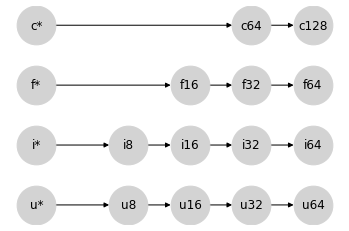

In [11]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'u*': ['u8'], 'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i*': ['i8'], 'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f*': ['f16'], 'f16': ['f32'], 'f32': ['f64'],
  'c*': ['c64'], 'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'u*': [0, 0], 'u8': [3, 0], 'u16': [5, 0], 'u32': [7, 0], 'u64': [9, 0],
  'i*': [0, 1], 'i8': [3, 1], 'i16': [5, 1], 'i32': [7, 1], 'i64': [9, 1],
  'f*': [0, 2], 'f16': [5, 2], 'f32': [7, 2], 'f64': [9, 2],
  'c*': [0, 3], 'c64': [7, 3], 'c128': [9, 3],
}
fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


在某种意义上，将标量放在左侧是一个奇怪的选择：标量类型可以包含任意宽度的值，但在与给定类型的数组交互时，提升结果会服从数组类型。这样做的好处是，当你对数组 `x` 执行操作，比如 `x + 2` 时，`x` 的类型将携带到结果中，无论其宽度如何：


In [12]:
for dtype in [np.int8, np.int16, np.int32, np.int64]:
  x = np.arange(10, dtype=dtype)
  assert (x + 2).dtype == dtype


这种行为为我们对标量值的 `*` 符号提供了动机：`*` 类似于可以取任何所需值的通配符。

这些语义的好处在于，你能够用简洁的 Python 代码轻松地表达操作序列，而不必显式地将标量转换为适当的类型。想象一下，如果不写这个：
```python
3 * (x + 1) ** 2
```
你不得不写这个：
```python
np.int32(3) * (x + np.int32(1)) ** np.int32(2)
```
虽然这是显式的，但数值代码会变得乏味和难以阅读。通过上述描述的标量提升语义，给定一个类型为 `int32` 的数组 `x`，第二条语句中的类型在第一条语句中是隐式的。


## 合并格

回想一下，我们开始讨论时介绍了表示 Python 中类型提升的格：`int -> float -> complex`。我们将其重写为 `i* -> f* -> c*`，并进一步允许 `i*` 包含 `u*`（毕竟，Python 中没有无符号整数标量类型）。

将这些全部结合在一起，我们得到以下部分格，表示 Python 标量和 numpy 数组之间的类型提升：


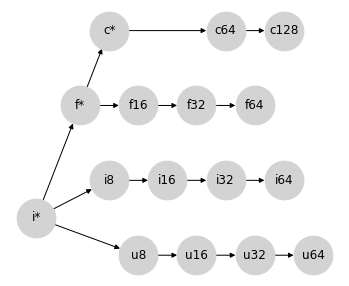

In [13]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


请注意，这还不是一个真正的格：存在许多节点对，它们没有定义的结合。然而，我们可以将其视为一个*部分*格，在这个格中，一些节点对没有定义的提升行为，而这个部分格中已定义的部分正确描述了NumPy的数组提升行为（不考虑上述提到的依赖于值的语义）。

这为我们提供了一个良好的框架，通过该框架我们可以考虑填补这些未定义的提升规则，通过在这个图上添加连接。但是，应该添加哪些连接呢？
广泛来说，我们希望任何额外的连接满足几个属性：

1. 提升应该满足交换律和结合律：换句话说，图应该保持一个（部分）格。

2. 提升绝不应允许丢失整个数据组件：例如，我们绝不应将 `complex` 提升为 `float`，因为这会丢弃任何虚部。

3. 提升绝不应导致未处理的溢出。例如，最大可能的 `uint32` 是最大可能的 `int32` 的两倍，因此我们不应隐式地将 `uint32` 提升为 `int32`。

4. 在可能的情况下，提升应避免精度损失。例如，`int64` 值可能有 64 位的尾数，因此将 `int64` 提升为 `float64` 代表了可能的精度损失。然而，最大可表示的 `float64` 大于最大可表示的 `int64`，因此在这种情况下，标准 #3 仍然得到满足。

5. 在可能的情况下，二进制提升应避免导致宽于输入的类型。这是为了确保 JAX 的隐式提升仍然适合以加速器为基础的工作流，在这些工作流中，用户通常希望将类型限制为 32 位（或在某些情况下 16 位）值。

格上的每个新连接为用户提供了一定程度的便利（一组可以在没有显式转换的情况下进行交互的类型），但如果违反上述任何标准，这种便利可能会变得过于昂贵。开发一个完整的提升格涉及在这种便利和成本之间取得平衡。


## 混合提升：浮点数和复数

让我们从最简单的情况开始，即浮点数和复数之间的提升。

复数由一对浮点数组成，因此在它们之间有一个自然的提升路径：将浮点数转换为复数，同时保持实部的宽度。根据我们部分格的表示，它看起来是这样的：


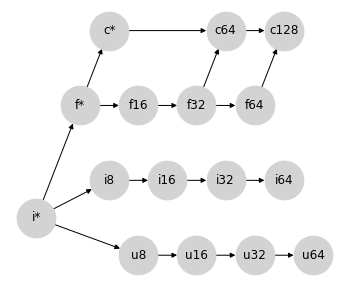

In [14]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16'], 'u16': ['u32'], 'u32': ['u64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


这恰好代表了Numpy在混合浮点/复数类型提升中使用的语义。


## 混合提升：带符号与不带符号的整数

对于下一个案例，让我们考虑一些更复杂的情况：带符号与不带符号整数之间的提升。例如，在将 `uint8` 提升为带符号整数时，我们需要多少位？

乍一看，你可能会认为将 `uint8` 提升为 `int8` 是自然的选择；但最大的 `uint8` 数字在 `int8` 中是无法表示的。因此，将不带符号整数提升为位数是其两倍的带符号整数更为合理；这种提升行为可以通过在提升格中添加以下连接来表示：


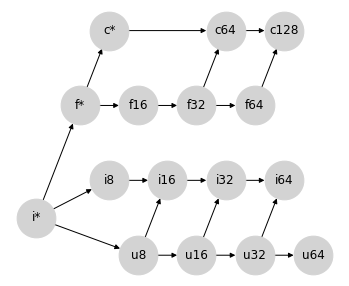

In [15]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


再次，这里添加的连接正是Numpy为混合整数提升实现的提升语义。


### 如何处理 `uint64`？

混合符号/无符号整数提升的方法忽略了一种类型：`uint64`。按照上述模式，涉及 `uint64` 的混合整数运算的输出应结果为 `int128`，但这并不是一个可用的标准数据类型。

Numpy 在这里的选择是提升为 `float64`：


In [16]:
(np.uint64(1) + np.int64(1)).dtype


dtype('float64')

然而，这可能是一个令人惊讶的约定：这是整数类型提升不产生整数的唯一情况。现在，我们将把 `uint64` 的提升状态设为未定义，稍后再回到这个问题。


## 混合提升：整数和浮点数

在将整数提升为浮点数时，我们可能会从与有符号和无符号整数之间混合提升相同的思维过程开始。一个 16 位的有符号或无符号整数无法通过只有 10 位尾数的 16 位浮点数以完全精度表示。因此，将整数提升为由两倍位数表示的浮点数可能是有意义的：


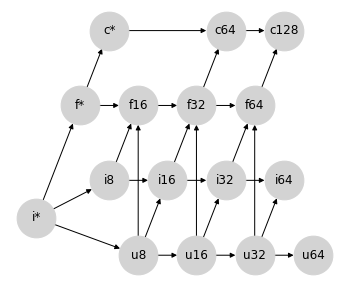

In [17]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16', 'f16'], 'u16': ['u32', 'i32', 'f32'], 'u32': ['u64', 'i64', 'f64'],
  'i8': ['i16', 'f16'], 'i16': ['i32', 'f32'], 'i32': ['i64', 'f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


这实际上就是Numpy类型提升所做的，但这样做破坏了图的格特性：例如，{i8, u8}这个对不再有唯一的最小上界：可能是i16和f16，而这两者在图上是不可排序的。这实际上是导致NumPy上述非结合性类型提升的原因。

我们是否可以提出一种修改NumPy提升规则的方法，使其满足格特性，同时在混合类型提升时也能给出合理的结果？我们可以采取几种方法。


### 选项 0：将整数/浮点混合精度保持未定义

为了使行为完全可预测（虽然会对用户便利性产生一定影响），一个合理的选择是将任何超出 Python 标量的混合整数/浮点提升保持未定义，停止于前一部分的部分格。缺点是用户在处理整数和浮点量之间时，需要明确进行类型转换。


### 选项 1：避免所有精度损失

如果我们的重点是尽一切可能避免精度损失，我们可以通过将无符号整数提升为浮点数来恢复晶格属性，方法是使用它们现有的有符号整数路径：


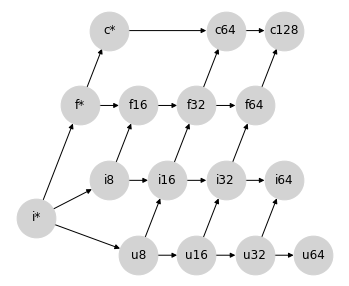

In [18]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16', 'f16'], 'i16': ['i32', 'f32'], 'i32': ['i64', 'f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [0.5, 2], 'f32': [1.5, 2], 'f64': [2.5, 2],
  'c64': [2, 3], 'c128': [3, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


这种方法的一个缺点是，它仍然使得 `int64` 和 `uint64` 的提升未定义，因为没有足够位数的标准浮点类型可以表示它们的全部值范围。我们可以放宽精度约束，通过从 `i64->f64` 和 `u64->f64` 绘制连接来完成这个格，但这些连接与该提升方案的初衷相悖。

第二个缺点是，这个格使得很难找到一个合理的地方来插入 `bfloat16`（见下文），同时保持格的属性。

这种方法的第三个缺点，对于 JAX 的加速器后端来说更为重要，是某些操作的结果产生的类型比必要的宽得多；例如，`uint16` 和 `float16` 之间的混合操作将全部提升到 `float64`，这并不理想。


### 选项 2：避免大多数不必要的宽类型提升

为了应对不必要的宽类型提升，我们可以接受在整数/浮点数提升时可能发生的某些精度损失，允许将有符号整数提升为相同宽度的浮点数：


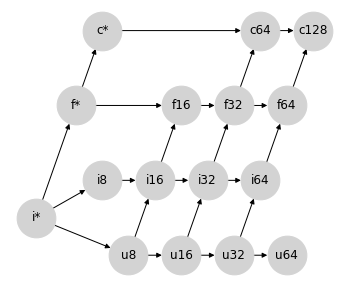

In [19]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['f*', 'u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['f16', 'i32'], 'i32': ['f32', 'i64'], 'i64': ['f64'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.5, 2], 'f32': [2.5, 2], 'f64': [3.5, 2],
  'c64': [3, 3], 'c128': [4, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


虽然这确实允许在整数和浮点数之间进行精度损失的提升，但这些提升不会错误地表示结果的*大小*：尽管浮点数的尾数不是足够宽以表示所有值，但指数足够宽以近似它们。

这种方法同样允许从 `int64` 自然提升到 `float64`，不过在这种方案中 `uint64` 仍然无法提升。也就是说，从 `u64` 到 `f64` 的联系在这里可以比之前更容易地辩解。

这种提升方案仍然产生了一些不必要的更宽提升路径；例如，`float32` 和 `uint32` 之间的操作结果是 `float64`。此外，这种格栅使得很难找到合适的位置以在保持格栅属性的同时插入 `bfloat16`（见下文）。


### 选项 3：避免所有不必要的宽泛提升

如果我们愿意从根本上改变对整数和浮点数提升的思考方式，我们可以避免*所有*不理想的 64 位提升。
正如标量总是依赖于数组类型的宽度一样，我们可以让整数总是依赖于浮点类型的宽度：


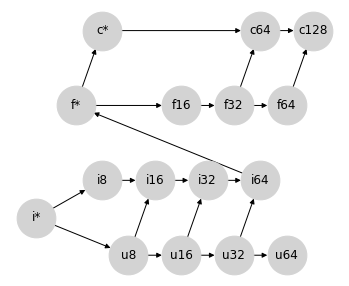

In [20]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.5, 2], 'f32': [2.5, 2], 'f64': [3.5, 2],
  'c64': [3, 3], 'c128': [4, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


这涉及到一个小把戏：之前我们使用 `f*` 来表示标量类型。在这个格中，`f*` 可能会应用于混合计算的数组输出。与其将 `f*` 视为标量，不如将其视为一种特殊的 `float` 值，具有不同的提升规则：在 JAX 中我们称之为 *弱浮点*；详见下文。

这种方法的优势在于，除无符号整数外，它避免了 *所有* 不必要的更高位数提升：您永远无法在没有 64 位输入的情况下获得 f64 输出，也永远无法在没有 32 位输入的情况下获得 f32 输出：这为在加速器上工作提供了方便的语义，同时避免了意外的 64 位值。

这种赋予浮点类型优先权的特性类似于 PyTorch 的类型提升行为。
这个格子还刚好生成了一个提升表，几乎与 JAX 原来的 *专门* 类型提升方案非常相似，该方案并不是基于一个格子，但具有赋予浮点类型优先权的特性。

这个格子还自然地提供了插入 `bfloat16` 的位置，而无需在 `bf16` 和 `f16` 之间强加一个顺序：


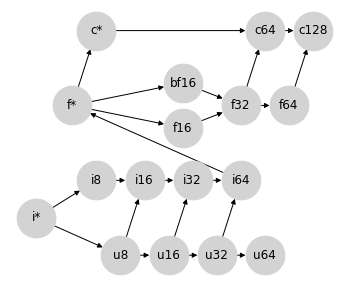

In [21]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16', 'bf16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'bf16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [-0.5, 2], 'c*': [0, 3],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [1.8, 1.7], 'bf16': [1.8, 2.3], 'f32': [3.0, 2], 'f64': [4.0, 2],
  'c64': [3.5, 3], 'c128': [4.5, 3],
}
fig, ax = plt.subplots(figsize=(6, 5))
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)


这很重要，因为 `f16` 和 `bf16` 不能比较，因为它们以不同的方式利用其位：`bf16` 以较低的精度表示更大的范围，而 `f16` 以较高的精度表示较小的范围。


然而，这些优势也伴随着一些权衡：

- 混合浮点/整数提升非常容易导致精度损失：例如，`int64`（最大值为 $9.2 \times 10^{18}$）可以提升为 `float16`（最大值为 $6.5 \times 10^4$），这意味着大多数可表示的值将变为 `inf`。
- 正如上面提到的，`f*` 不再被视为“标量类型”，而是被视为 float64 的另一种变体。在 JAX 的术语中，这被称为 [*弱类型*](https://jax.readthedocs.io/en/latest/type_promotion.html#weakly-typed-values-in-jax)，因为它被表示为 64 位，但在与其他值的提升中仅弱地遵循此位宽。

请注意，这种方法仍然没有解答 `uint64` 的提升问题，尽管将 `u64` 连接到 `f*` 可能是合理的。


## JAX中的类型提升

在设计JAX的类型提升语义时，我们考虑了许多这些思想，并且在以下几方面做了大量依赖：

1. 我们选择将JAX的类型提升语义限制在满足格属性的图上：这是为了确保结合性和交换性，同时也允许语义在有向无环图中被紧凑地描述，而不必依赖一个较大的表格。

2. 我们倾向于避免无意间提升到更宽类型的语义，特别是在浮点值方面，以便在加速器上受益于计算。

3. 我们接受在混合类型提升中可能精度丧失（但不是量级丧失），如果这对于维持(1)和(2)是必要的。

考虑到这一点，JAX采纳了选项3。或者更确切地说，这是选项3的一个稍微修改过的版本，它建立了`u64`和`f*`之间的联系，以创建一个真正的格。
为了清晰起见，JAX的类型提升格如下所示：


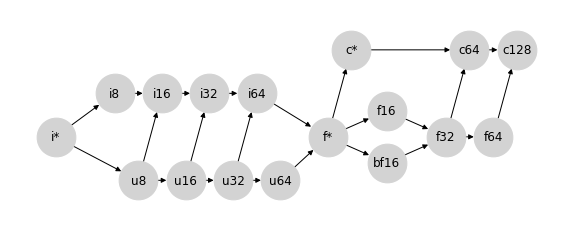

In [22]:
#@标题
import networkx as nx
import matplotlib.pyplot as plt
lattice = {
  'i*': ['u8', 'i8'], 'f*': ['c*', 'f16', 'bf16'], 'c*': ['c64'],
  'u8': ['u16', 'i16'], 'u16': ['u32', 'i32'], 'u32': ['u64', 'i64'], 'u64': ['f*'],
  'i8': ['i16'], 'i16': ['i32'], 'i32': ['i64'], 'i64': ['f*'],
  'f16': ['f32'], 'bf16': ['f32'], 'f32': ['f64', 'c64'], 'f64': ['c128'],
  'c64': ['c128']
}
graph = nx.from_dict_of_lists(lattice, create_using=nx.DiGraph)
pos = {
  'i*': [-1.25, 0.5], 'f*': [4.5, 0.5], 'c*': [5, 1.5],
  'u8': [0.5, 0], 'u16': [1.5, 0], 'u32': [2.5, 0], 'u64': [3.5, 0],
  'i8': [0, 1], 'i16': [1, 1], 'i32': [2, 1], 'i64': [3, 1],
  'f16': [5.75, 0.8], 'bf16': [5.75, 0.2], 'f32': [7, 0.5], 'f64': [8, 0.5],
  'c64': [7.5, 1.5], 'c128': [8.5, 1.5],
}
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylim(-0.5, 2)
nx.draw(graph, with_labels=True, node_size=1500, node_color='lightgray', pos=pos, ax=ax)
# ax.patches[12].set_linestyle((0, (2, 4)))


此选择所导致的行为总结在[JAX类型提升语义](https://jax.readthedocs.io/en/latest/type_promotion.html)中。值得注意的是，除了包含更大的无符号类型（`u16`，`u32`，`u64`）和一些关于标量/弱类型（`i*`，`f*`，`c*`）行为的细节外，这种类型提升方案与PyTorch选择的方案非常接近。

对于感兴趣的读者，下面的附录打印了NumPy、Tensorflow、PyTorch和JAX使用的完整提升表。


## 附录：示例类型提升表

以下是一些由各种Python数组计算库实现的隐式类型提升表的示例。


### NumPy 类型提升

请注意，NumPy 不包括 `bfloat16` 数据类型，并且下表忽略了依赖于值的影响。


In [1]:
# @标题

import numpy as np
import pandas as pd
from IPython import display

np_dtypes = {
  'b': np.bool_,
  'u8': np.uint8, 'u16': np.uint16, 'u32': np.uint32, 'u64': np.uint64,
  'i8': np.int8, 'i16': np.int16, 'i32': np.int32, 'i64': np.int64,
  'bf16': 'invalid', 'f16': np.float16, 'f32': np.float32, 'f64': np.float64,
  'c64': np.complex64, 'c128': np.complex128,
  'i*': int, 'f*': float, 'c*': complex}

np_dtype_to_code = {val: key for key, val in np_dtypes.items()}

def make_np_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return np.zeros(1, dtype=dtype)

def np_result_code(dtype1, dtype2):
  try:
    out = np.add(make_np_zero(dtype1), make_np_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return np_dtype_to_code[type(out)]
    else:
      return np_dtype_to_code[out.dtype.type]


grid = [[np_result_code(dtype1, dtype2)
         for dtype2 in np_dtypes.values()]
        for dtype1 in np_dtypes.values()]
table = pd.DataFrame(grid, index=np_dtypes.keys(), columns=np_dtypes.keys())
display.HTML(table.to_html())


### Tensorflow 类型提升

Tensorflow 避免定义隐式类型提升，除非在有限情况下涉及 Python 标量。该表是不对称的，因为在 `tf.add(x, y)` 中，`y` 的类型必须能够强制转换为 `x` 的类型。


In [23]:
# @标题

import tensorflow as tf
import pandas as pd
from IPython import display

tf_dtypes = {
  'b': tf.bool,
  'u8': tf.uint8, 'u16': tf.uint16, 'u32': tf.uint32, 'u64': tf.uint64,
  'i8': tf.int8, 'i16': tf.int16, 'i32': tf.int32, 'i64': tf.int64,
  'bf16': tf.bfloat16, 'f16': tf.float16, 'f32': tf.float32, 'f64': tf.float64,
  'c64': tf.complex64, 'c128': tf.complex128,
  'i*': int, 'f*': float, 'c*': complex}

tf_dtype_to_code = {val: key for key, val in tf_dtypes.items()}

def make_tf_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return tf.zeros(1, dtype=dtype)

def result_code(dtype1, dtype2):
  try:
    out = tf.add(make_tf_zero(dtype1), make_tf_zero(dtype2))
  except (TypeError, tf.errors.InvalidArgumentError):
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return tf_dtype_to_code[type(out)]
    else:
      return tf_dtype_to_code[out.dtype]


grid = [[result_code(dtype1, dtype2)
         for dtype2 in tf_dtypes.values()]
        for dtype1 in tf_dtypes.values()]
table = pd.DataFrame(grid, index=tf_dtypes.keys(), columns=tf_dtypes.keys())
display.HTML(table.to_html())


### PyTorch 类型提升

注意，torch 不包括大于 `uint8` 的无符号整数类型。除了这一点和一些关于与标量/弱类型的提升细节之外，该表与 `jax.numpy` 使用的表格相近。


In [3]:
# @标题
import torch
import pandas as pd
from IPython import display

torch_dtypes = {
  'b': torch.bool,
  'u8': torch.uint8, 'u16': 'invalid', 'u32': 'invalid', 'u64': 'invalid',
  'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64,
  'bf16': torch.bfloat16, 'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64,
  'c64': torch.complex64, 'c128': torch.complex128,
  'i*': int, 'f*': float, 'c*': complex}

torch_dtype_to_code = {val: key for key, val in torch_dtypes.items()}

def make_torch_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return torch.zeros(1, dtype=dtype)

def torch_result_code(dtype1, dtype2):
  try:
    out = torch.add(make_torch_zero(dtype1), make_torch_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if type(out) in {int, float, complex}:
      return torch_dtype_to_code[type(out)]
    else:
      return torch_dtype_to_code[out.dtype]


grid = [[torch_result_code(dtype1, dtype2)
         for dtype2 in torch_dtypes.values()]
        for dtype1 in torch_dtypes.values()]
table = pd.DataFrame(grid, index=torch_dtypes.keys(), columns=torch_dtypes.keys())
display.HTML(table.to_html())


### JAX 类型提升：`jax.numpy`

`jax.numpy` 遵循在 https://jax.readthedocs.io/en/latest/type_promotion.html 中列出的类型提升规则。在这里，我们使用 `i*`、`f*`、`c*` 来表示 Python 标量和弱类型数组。


In [26]:
# @标题
import jax
import jax.numpy as jnp
import pandas as pd
from IPython import display
jax.config.update('jax_enable_x64', True)

jnp_dtypes = {
  'b': jnp.bool_.dtype,
  'u8': jnp.uint8.dtype, 'u16': jnp.uint16.dtype, 'u32': jnp.uint32.dtype, 'u64': jnp.uint64.dtype,
  'i8': jnp.int8.dtype, 'i16': jnp.int16.dtype, 'i32': jnp.int32.dtype, 'i64': jnp.int64.dtype,
  'bf16': jnp.bfloat16.dtype, 'f16': jnp.float16.dtype, 'f32': jnp.float32.dtype, 'f64': jnp.float64.dtype,
  'c64': jnp.complex64.dtype, 'c128': jnp.complex128.dtype,
  'i*': int, 'f*': float, 'c*': complex}


jnp_dtype_to_code = {val: key for key, val in jnp_dtypes.items()}

def make_jnp_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return jnp.zeros((), dtype=dtype)

def jnp_result_code(dtype1, dtype2):
  try:
    out = jnp.add(make_jnp_zero(dtype1), make_jnp_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if hasattr(out, 'aval') and out.aval.weak_type:
      return out.dtype.kind + '*'
    elif type(out) in {int, float, complex}:
      return jnp_dtype_to_code[type(out)]
    else:
      return jnp_dtype_to_code[out.dtype]

grid = [[jnp_result_code(dtype1, dtype2)
         for dtype2 in jnp_dtypes.values()]
        for dtype1 in jnp_dtypes.values()]
table = pd.DataFrame(grid, index=jnp_dtypes.keys(), columns=jnp_dtypes.keys())
display.HTML(table.to_html())


### JAX 类型提升：`jax.lax`
`jax.lax` 是较低级的，不进行任何隐式提升。在这里，我们使用 `i*`、`f*`、`c*` 来表示 Python 标量和弱类型数组。


In [5]:
# @标题
import jax
import jax.numpy as jnp
import pandas as pd
from IPython import display
jax.config.update('jax_enable_x64', True)

jnp_dtypes = {
  'b': jnp.bool_.dtype,
  'u8': jnp.uint8.dtype, 'u16': jnp.uint16.dtype, 'u32': jnp.uint32.dtype, 'u64': jnp.uint64.dtype,
  'i8': jnp.int8.dtype, 'i16': jnp.int16.dtype, 'i32': jnp.int32.dtype, 'i64': jnp.int64.dtype,
  'bf16': jnp.bfloat16.dtype, 'f16': jnp.float16.dtype, 'f32': jnp.float32.dtype, 'f64': jnp.float64.dtype,
  'c64': jnp.complex64.dtype, 'c128': jnp.complex128.dtype,
  'i*': int, 'f*': float, 'c*': complex}


jnp_dtype_to_code = {val: key for key, val in jnp_dtypes.items()}

def make_jnp_zero(dtype):
  if dtype in {int, float, complex}:
    return dtype(0)
  else:
    return jnp.zeros((), dtype=dtype)

def jnp_result_code(dtype1, dtype2):
  try:
    out = jax.lax.add(make_jnp_zero(dtype1), make_jnp_zero(dtype2))
  except TypeError:
    return '-'
  else:
    if hasattr(out, 'aval') and out.aval.weak_type:
      return out.dtype.kind + '*'
    elif type(out) in {int, float, complex}:
      return jnp_dtype_to_code[type(out)]
    else:
      return jnp_dtype_to_code[out.dtype]

grid = [[jnp_result_code(dtype1, dtype2)
         for dtype2 in jnp_dtypes.values()]
        for dtype1 in jnp_dtypes.values()]
table = pd.DataFrame(grid, index=jnp_dtypes.keys(), columns=jnp_dtypes.keys())
display.HTML(table.to_html())
